# **XLM-Cross-lingual Language Model.**

### **Installing Required Libraries for Transformers, Datasets, and PyTorch**

In [ ]:
!pip install transformers datasets torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing

### **Importing Required Libraries for Model Training and Evaluation**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix)
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import (XLMRobertaTokenizer, XLMRobertaModel,
                         XLMRobertaConfig, XLMRobertaForSequenceClassification,
                         get_linear_schedule_with_warmup)
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Check for available device (CPU, GPU, TPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants
MODEL_NAME = "xlm-roberta-base"
MAX_LENGTH = 256
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
LABEL_COLUMNS = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

2025-04-13 03:31:18.030768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744515078.231236      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744515078.290651      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Transformers version: 4.51.1
PyTorch version: 2.5.1+cu124
Using device: cuda


### **Custom Dataset Class for Toxicity Data and Multi-Label Classification Model**

In [ ]:
# Custom dataset class for toxicity data
class ToxicityDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, text_column, label_columns=None):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe[text_column]
        self.max_length = max_length
        self.label_columns = label_columns

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])

        # Tokenize the text
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Create dictionary with inputs
        item = {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs['token_type_ids'].flatten()
        }

        # Add labels if provided
        if self.label_columns:
            labels = torch.FloatTensor(self.data[self.label_columns].iloc[index].values)
            item['labels'] = labels

        return item

class XLMRobertaForMultiLabelSequenceClassification(torch.nn.Module):
    def __init__(self, num_labels=6):
        super(XLMRobertaForMultiLabelSequenceClassification, self).__init__()
        self.num_labels = num_labels

        # Load pre-trained XLM-RoBERTa model
        self.roberta = XLMRobertaModel.from_pretrained(MODEL_NAME)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(0.2)

        # Classifier for multi-label prediction (all 6 toxicity dimensions)
        self.classifier = torch.nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        # Get RoBERTa embeddings
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Get the [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)

        # Get logits for all 6 dimensions
        logits = self.classifier(pooled_output)

        # Initialize return dictionary
        result = {"logits": logits}

        # Calculate loss if labels are provided
        if labels is not None:
            # Handle different label dimensions (for validation with only 'toxic' label)
            if labels.shape[1] == 1 and logits.shape[1] > 1:
                # Only compute loss for the first dimension (toxic)
                loss_fct = torch.nn.BCEWithLogitsLoss(
                    pos_weight=torch.tensor([weights[0]], device=input_ids.device)
                )
                loss = loss_fct(logits[:, 0].view(-1), labels.view(-1))
            else:
                # Full multi-label loss computation
                loss_fct = torch.nn.BCEWithLogitsLoss(
                    pos_weight=torch.tensor(weights, device=input_ids.device)
                )
                loss = loss_fct(logits, labels)

            result["loss"] = loss

        return result

### **Loading Datasets and Performing EDA: Label Distribution, Class Weights, and Text Length Analysis**

Dataset shapes:
Training: (23473, 8)
Validation: (840, 4)
Test (features): (6000, 3)
Test Labels: (6000, 2)

Training label distribution:
toxic: 2196 positive (9.36%), 21277 negative
abusive: 176 positive (0.75%), 23297 negative
vulgar: 1275 positive (5.43%), 22198 negative
menace: 66 positive (0.28%), 23407 negative
offense: 1150 positive (4.90%), 22323 negative
bigotry: 193 positive (0.82%), 23280 negative

Class weights for handling imbalance:
toxic: 9.6890
abusive: 132.3693
vulgar: 17.4102
menace: 354.6515
offense: 19.4113
bigotry: 120.6218


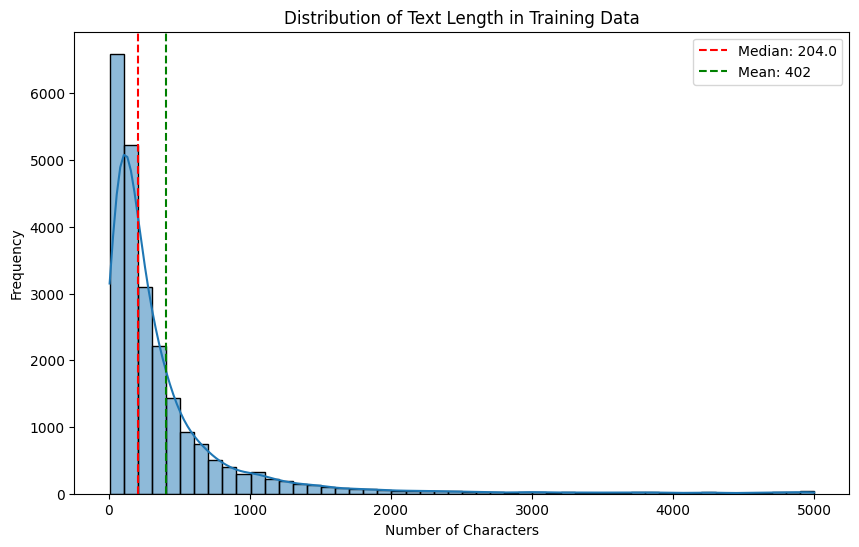

In [ ]:
# Load datasets
train_df = pd.read_csv('train.csv')
validation_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')
test_labels_df = pd.read_csv('test_labels.csv')

print("Dataset shapes:")
print(f"Training: {train_df.shape}")
print(f"Validation: {validation_df.shape}")
print(f"Test (features): {test_df.shape}")
print(f"Test Labels: {test_labels_df.shape}")

# EDA: Label distribution analysis
print("\nTraining label distribution:")
for column in LABEL_COLUMNS:
    positive_count = train_df[column].sum()
    total = len(train_df)
    print(f"{column}: {positive_count} positive ({positive_count/total*100:.2f}%), {total-positive_count} negative")

# Calculate weights for loss function to handle class imbalance
weights = []
for column in LABEL_COLUMNS:
    pos_count = train_df[column].sum()
    neg_count = len(train_df) - pos_count
    # Weight = number of negative examples divided by number of positive examples
    weights.append(neg_count / pos_count if pos_count > 0 else 1.0)

print("\nClass weights for handling imbalance:")
for col, weight in zip(LABEL_COLUMNS, weights):
    print(f"{col}: {weight:.4f}")

# EDA: Text length analysis
train_df['text_length'] = train_df['feedback_text'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length in Training Data')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.axvline(x=train_df['text_length'].median(), color='r', linestyle='--',
            label=f"Median: {train_df['text_length'].median()}")
plt.axvline(x=train_df['text_length'].mean(), color='g', linestyle='--',
            label=f"Mean: {int(train_df['text_length'].mean())}")
plt.legend()
plt.show()

### **Model Initialization, Training Loop, and Saving Best Model**

In [ ]:
# Initialize tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

# Create datasets
train_dataset = ToxicityDataset(
    dataframe=train_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    text_column='feedback_text',
    label_columns=LABEL_COLUMNS
)

# Check if validation dataframe has all label columns
val_label_columns = [col for col in LABEL_COLUMNS if col in validation_df.columns]
print(f"Using validation label columns: {val_label_columns}")

validation_dataset = ToxicityDataset(
    dataframe=validation_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    text_column='feedback_text',
    label_columns=val_label_columns
)

# Create data loaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Initialize model
model = XLMRobertaForMultiLabelSequenceClassification(num_labels=len(LABEL_COLUMNS))
model.to(device)

# Initialize optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Training loop
best_val_f1 = 0
best_threshold = 0.5
model_save_path = 'best_xlm_roberta_model.pth'  # Changed extension to avoid pickle issues

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    progress_bar = tqdm(train_dataloader, desc="Training")

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs["loss"]
        train_loss += loss.item() * input_ids.size(0)

        # Calculate accuracy (just for reporting)
        logits = outputs["logits"]
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        correct = (preds == labels).float().sum()
        train_acc += correct.item()
        train_samples += labels.numel()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / train_samples
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2f}")

    # Validation phase
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs["loss"]
            val_loss += loss.item() * input_ids.size(0)

            # Get predictions (focus on toxic dimension only for validation)
            logits = outputs["logits"]
            probs = torch.sigmoid(logits)

            all_preds.append(probs.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

    # Calculate average validation loss
    avg_val_loss = val_loss / len(validation_dataloader.dataset)

    # Combine predictions and labels
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Try different thresholds to find the best one
    thresholds = np.arange(0.3, 0.7, 0.05)
    threshold_results = {}

    for threshold in thresholds:
        preds_t = (all_preds > threshold).astype(int)

        # Focus on toxic dimension only for validation
        toxic_preds = preds_t[:, 0]
        toxic_labels = all_labels[:, 0]

        accuracy = accuracy_score(toxic_labels, toxic_preds)
        precision = precision_score(toxic_labels, toxic_preds, zero_division=0)
        recall = recall_score(toxic_labels, toxic_preds, zero_division=0)
        f1 = f1_score(toxic_labels, toxic_preds, zero_division=0)

        threshold_results[threshold] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        print(f"Threshold {threshold:.2f} - Val Loss: {avg_val_loss:.4f} | "
              f"Acc: {accuracy:.2f} | Precision: {precision:.2f} | "
              f"Recall: {recall:.2f} | F1: {f1:.2f}")

    # Find best threshold based on F1 score
    best_epoch_threshold = max(threshold_results.items(),
                               key=lambda x: x[1]['f1'])[0]
    best_epoch_metrics = threshold_results[best_epoch_threshold]

    print(f"Best threshold: {best_epoch_threshold:.2f} with "
          f"F1: {best_epoch_metrics['f1']:.4f}")

    # Save best model
    if best_epoch_metrics['f1'] > best_val_f1:
        best_val_f1 = best_epoch_metrics['f1']
        best_threshold = best_epoch_threshold

        # Save model - using direct state dict saving to avoid pickle issues
        torch.save({
            'model_state_dict': model.state_dict(),
            'threshold': best_threshold,
            'val_f1': best_val_f1
        }, model_save_path)

        print(f"New best model saved with F1: {best_val_f1:.4f}")

print("\nTraining completed!")
print(f"Best model saved at: {model_save_path}")
print(f"Best validation F1: {best_val_f1:.4f}")
print(f"Best threshold: {best_threshold:.2f}")

# Save threshold separately in case we need it
with open('best_threshold.txt', 'w') as f:
    f.write(str(best_threshold))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Using validation label columns: ['toxic']


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]


Epoch 1/5


Training:   0%|          | 0/1468 [00:00<?, ?it/s]

Train Loss: 0.7966 | Train Acc: 0.79


Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Threshold 0.30 - Val Loss: 1.2797 | Acc: 0.80 | Precision: 0.42 | Recall: 0.75 | F1: 0.54
Threshold 0.35 - Val Loss: 1.2797 | Acc: 0.81 | Precision: 0.45 | Recall: 0.75 | F1: 0.56
Threshold 0.40 - Val Loss: 1.2797 | Acc: 0.82 | Precision: 0.45 | Recall: 0.71 | F1: 0.55
Threshold 0.45 - Val Loss: 1.2797 | Acc: 0.83 | Precision: 0.48 | Recall: 0.70 | F1: 0.57
Threshold 0.50 - Val Loss: 1.2797 | Acc: 0.83 | Precision: 0.49 | Recall: 0.68 | F1: 0.57
Threshold 0.55 - Val Loss: 1.2797 | Acc: 0.83 | Precision: 0.49 | Recall: 0.65 | F1: 0.56
Threshold 0.60 - Val Loss: 1.2797 | Acc: 0.84 | Precision: 0.51 | Recall: 0.63 | F1: 0.56
Threshold 0.65 - Val Loss: 1.2797 | Acc: 0.85 | Precision: 0.52 | Recall: 0.61 | F1: 0.56
Best threshold: 0.45 with F1: 0.5680
New best model saved with F1: 0.5680

Epoch 2/5


Training:   0%|          | 0/1468 [00:00<?, ?it/s]

Train Loss: 0.4093 | Train Acc: 0.90


Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Threshold 0.30 - Val Loss: 2.0468 | Acc: 0.83 | Precision: 0.48 | Recall: 0.56 | F1: 0.52
Threshold 0.35 - Val Loss: 2.0468 | Acc: 0.84 | Precision: 0.49 | Recall: 0.54 | F1: 0.51
Threshold 0.40 - Val Loss: 2.0468 | Acc: 0.84 | Precision: 0.50 | Recall: 0.53 | F1: 0.51
Threshold 0.45 - Val Loss: 2.0468 | Acc: 0.85 | Precision: 0.53 | Recall: 0.51 | F1: 0.52
Threshold 0.50 - Val Loss: 2.0468 | Acc: 0.86 | Precision: 0.58 | Recall: 0.50 | F1: 0.54
Threshold 0.55 - Val Loss: 2.0468 | Acc: 0.87 | Precision: 0.60 | Recall: 0.48 | F1: 0.53
Threshold 0.60 - Val Loss: 2.0468 | Acc: 0.87 | Precision: 0.63 | Recall: 0.45 | F1: 0.52
Threshold 0.65 - Val Loss: 2.0468 | Acc: 0.87 | Precision: 0.65 | Recall: 0.40 | F1: 0.50
Best threshold: 0.50 with F1: 0.5360

Epoch 3/5


Training:   0%|          | 0/1468 [00:00<?, ?it/s]

Train Loss: 0.3019 | Train Acc: 0.93


Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Threshold 0.30 - Val Loss: 1.9038 | Acc: 0.83 | Precision: 0.48 | Recall: 0.65 | F1: 0.55
Threshold 0.35 - Val Loss: 1.9038 | Acc: 0.84 | Precision: 0.49 | Recall: 0.63 | F1: 0.55
Threshold 0.40 - Val Loss: 1.9038 | Acc: 0.84 | Precision: 0.51 | Recall: 0.60 | F1: 0.55
Threshold 0.45 - Val Loss: 1.9038 | Acc: 0.84 | Precision: 0.51 | Recall: 0.56 | F1: 0.53
Threshold 0.50 - Val Loss: 1.9038 | Acc: 0.85 | Precision: 0.52 | Recall: 0.54 | F1: 0.53
Threshold 0.55 - Val Loss: 1.9038 | Acc: 0.85 | Precision: 0.53 | Recall: 0.50 | F1: 0.51
Threshold 0.60 - Val Loss: 1.9038 | Acc: 0.85 | Precision: 0.55 | Recall: 0.49 | F1: 0.52
Threshold 0.65 - Val Loss: 1.9038 | Acc: 0.86 | Precision: 0.58 | Recall: 0.46 | F1: 0.51
Best threshold: 0.30 with F1: 0.5541

Epoch 4/5


Training:   0%|          | 0/1468 [00:00<?, ?it/s]

Train Loss: 0.2419 | Train Acc: 0.94


Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Threshold 0.30 - Val Loss: 1.6029 | Acc: 0.83 | Precision: 0.48 | Recall: 0.71 | F1: 0.57
Threshold 0.35 - Val Loss: 1.6029 | Acc: 0.83 | Precision: 0.48 | Recall: 0.66 | F1: 0.55
Threshold 0.40 - Val Loss: 1.6029 | Acc: 0.83 | Precision: 0.49 | Recall: 0.63 | F1: 0.55
Threshold 0.45 - Val Loss: 1.6029 | Acc: 0.84 | Precision: 0.49 | Recall: 0.61 | F1: 0.54
Threshold 0.50 - Val Loss: 1.6029 | Acc: 0.85 | Precision: 0.51 | Recall: 0.60 | F1: 0.55
Threshold 0.55 - Val Loss: 1.6029 | Acc: 0.85 | Precision: 0.53 | Recall: 0.57 | F1: 0.55
Threshold 0.60 - Val Loss: 1.6029 | Acc: 0.86 | Precision: 0.57 | Recall: 0.54 | F1: 0.56
Threshold 0.65 - Val Loss: 1.6029 | Acc: 0.87 | Precision: 0.59 | Recall: 0.51 | F1: 0.55
Best threshold: 0.30 with F1: 0.5740
New best model saved with F1: 0.5740

Epoch 5/5


Training:   0%|          | 0/1468 [00:00<?, ?it/s]

Train Loss: 0.1965 | Train Acc: 0.95


Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Threshold 0.30 - Val Loss: 1.9626 | Acc: 0.84 | Precision: 0.50 | Recall: 0.64 | F1: 0.56
Threshold 0.35 - Val Loss: 1.9626 | Acc: 0.84 | Precision: 0.50 | Recall: 0.61 | F1: 0.55
Threshold 0.40 - Val Loss: 1.9626 | Acc: 0.84 | Precision: 0.51 | Recall: 0.59 | F1: 0.54
Threshold 0.45 - Val Loss: 1.9626 | Acc: 0.85 | Precision: 0.52 | Recall: 0.55 | F1: 0.54
Threshold 0.50 - Val Loss: 1.9626 | Acc: 0.85 | Precision: 0.53 | Recall: 0.53 | F1: 0.53
Threshold 0.55 - Val Loss: 1.9626 | Acc: 0.86 | Precision: 0.55 | Recall: 0.51 | F1: 0.53
Threshold 0.60 - Val Loss: 1.9626 | Acc: 0.86 | Precision: 0.59 | Recall: 0.50 | F1: 0.54
Threshold 0.65 - Val Loss: 1.9626 | Acc: 0.87 | Precision: 0.62 | Recall: 0.49 | F1: 0.55
Best threshold: 0.30 with F1: 0.5603

Training completed!
Best model saved at: best_xlm_roberta_model.pth
Best validation F1: 0.5740
Best threshold: 0.30


### **Loading Trained Model and Evaluating on Validation Data**

Using threshold: 0.30


Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Val Loss: 1.6029 | Acc: 0.83 | Precision: 0.48 | Recall: 0.71 | F1: 0.57

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       706
         1.0       0.48      0.71      0.57       134

    accuracy                           0.83       840
   macro avg       0.71      0.78      0.73       840
weighted avg       0.87      0.83      0.84       840



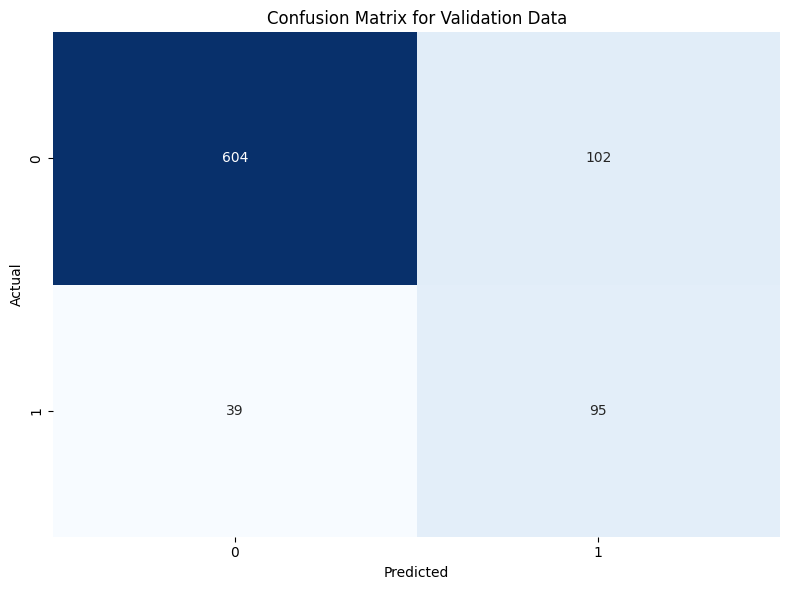

In [ ]:
# Load threshold from training
try:
    with open('best_threshold.txt', 'r') as f:
        threshold = float(f.read().strip())
except FileNotFoundError:
    threshold = 0.5 

print(f"Using threshold: {threshold:.2f}")

# Initialize model
model = XLMRobertaForMultiLabelSequenceClassification(num_labels=len(LABEL_COLUMNS))
model_save_path = 'best_xlm_roberta_model.pth'

# Load model weights directly with safe loading to avoid pickle errors
try:
    checkpoint = torch.load(model_save_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
except RuntimeError:
    # Attempt with weights_only=False if the first method fails
    print("First loading attempt failed, trying with weights_only=False...")
    checkpoint = torch.load(model_save_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
model.eval()

# Set up validation data if needed
# If you already have validation_dataloader from the training phase, you can skip this
if 'validation_dataloader' not in locals():
    tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)
    val_label_columns = [col for col in LABEL_COLUMNS if col in validation_df.columns]

    validation_dataset = ToxicityDataset(
        dataframe=validation_df,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        text_column='feedback_text',
        label_columns=val_label_columns
    )

    validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

# Validation evaluation
all_preds = []
all_labels = []
val_loss = 0

with torch.no_grad():
    for batch in tqdm(validation_dataloader, desc="Validation"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs["loss"] if "loss" in outputs else 0
        if "loss" in outputs:
            val_loss += loss.item() * input_ids.size(0)

        # Get predictions
        logits = outputs["logits"]
        probs = torch.sigmoid(logits)

        all_preds.append(probs.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

# Calculate average validation loss
if len(validation_dataloader.dataset) > 0:
    avg_val_loss = val_loss / len(validation_dataloader.dataset)
else:
    avg_val_loss = 0

# Combine predictions and labels
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Apply threshold to get binary predictions
binary_preds = (all_preds > threshold).astype(int)

# Focus on toxic dimension only
toxic_preds = binary_preds[:, 0]
toxic_labels = all_labels[:, 0]

# Calculate metrics
accuracy = accuracy_score(toxic_labels, toxic_preds)
precision = precision_score(toxic_labels, toxic_preds, zero_division=0)
recall = recall_score(toxic_labels, toxic_preds, zero_division=0)
f1 = f1_score(toxic_labels, toxic_preds, zero_division=0)

# Print validation results
print(f"Val Loss: {avg_val_loss:.4f} | Acc: {accuracy:.2f} | "
      f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

# Print detailed classification report
print("\nValidation Classification Report:")
print(classification_report(toxic_labels, toxic_preds))

# Plot confusion matrix
cm = confusion_matrix(toxic_labels, toxic_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### **Loading Model, Making Predictions, and Evaluating on Test Data**

Using threshold: 0.30
Using 'content' as text column for test data


Testing:   0%|          | 0/375 [00:00<?, ?it/s]

Predictions saved to 'predicted_test_labels.csv'

Test Scores - Acc: 0.81 | Precision: 0.56 | Recall: 0.79 | F1: 0.65

Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4637
           1       0.56      0.79      0.65      1363

    accuracy                           0.81      6000
   macro avg       0.74      0.80      0.76      6000
weighted avg       0.84      0.81      0.82      6000



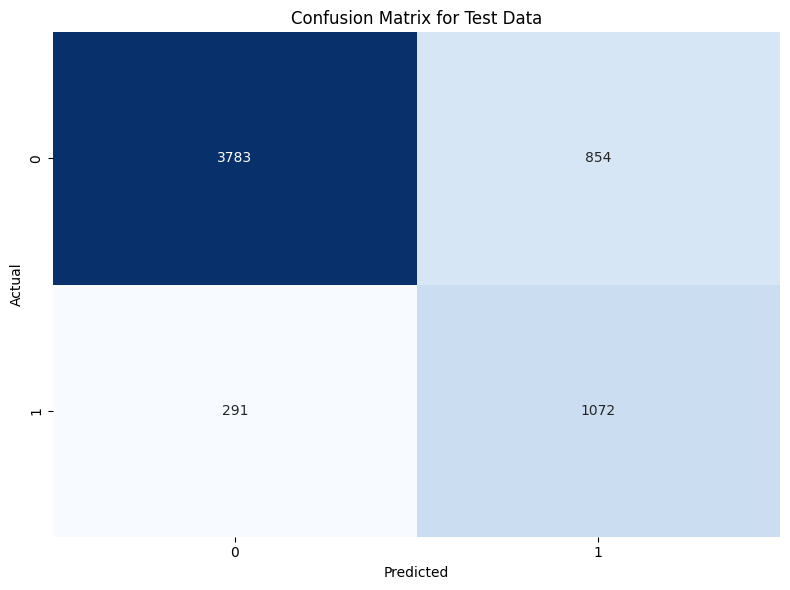

In [ ]:
# Load threshold from training
try:
    with open('best_threshold.txt', 'r') as f:
        threshold = float(f.read().strip())
except FileNotFoundError:
    threshold = 0.5  # Default if file not found

print(f"Using threshold: {threshold:.2f}")

# Initialize or reuse model
if 'model' not in locals() or not isinstance(model, XLMRobertaForMultiLabelSequenceClassification):
    model = XLMRobertaForMultiLabelSequenceClassification(num_labels=len(LABEL_COLUMNS))
    model_save_path = 'best_xlm_roberta_model.pth'

    # Load model weights - with safe loading to avoid pickle errors
    try:
        checkpoint = torch.load(model_save_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    except RuntimeError:
        # Attempt with weights_only=False if the first method fails
        print("First loading attempt failed, trying with weights_only=False...")
        checkpoint = torch.load(model_save_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

    model.to(device)

model.eval()

# Create test dataloader
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)
test_text_column = 'content' if 'content' in test_df.columns else 'feedback_text'
print(f"Using '{test_text_column}' as text column for test data")

test_dataset = ToxicityDataset(
    dataframe=test_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    text_column=test_text_column,
    label_columns=None  # No labels for prediction
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Testing loop
all_predictions = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Get predictions for 'toxic' (first dimension)
        logits = outputs["logits"]
        probs = torch.sigmoid(logits)
        toxic_probs = probs[:, 0]
        toxic_preds = (toxic_probs > threshold).int()

        all_predictions.extend(toxic_preds.cpu().numpy().tolist())

# Create test predictions dataframe
test_predictions = pd.DataFrame({
    'id': test_df['id'].tolist(),
    'toxic': all_predictions
})

# Save predictions
predictions_path = 'predicted_test_labels.csv'
test_predictions.to_csv(predictions_path, index=False)
print(f"Predictions saved to '{predictions_path}'")

# Evaluate against test labels if available
if 'test_labels_df' in locals() and test_labels_df is not None:
    # Merge predictions with true labels
    test_predictions_sorted = test_predictions.set_index('id')
    test_labels_sorted = test_labels_df.set_index('id')

    # Align indexes
    test_predictions_sorted, test_labels_sorted = test_predictions_sorted.align(
        test_labels_sorted, join='inner', axis=0)

    # Calculate metrics
    accuracy = accuracy_score(test_labels_sorted['toxic'], test_predictions_sorted['toxic'])
    precision = precision_score(test_labels_sorted['toxic'], test_predictions_sorted['toxic'], zero_division=0)
    recall = recall_score(test_labels_sorted['toxic'], test_predictions_sorted['toxic'], zero_division=0)
    f1 = f1_score(test_labels_sorted['toxic'], test_predictions_sorted['toxic'], zero_division=0)

    print("\nTest Scores - "
          f"Acc: {accuracy:.2f} | Precision: {precision:.2f} | "
          f"Recall: {recall:.2f} | F1: {f1:.2f}")

    # Print detailed classification report
    print("\nTest Classification Report:")
    print(classification_report(test_labels_sorted['toxic'], test_predictions_sorted['toxic']))

    # Plot confusion matrix
    cm = confusion_matrix(test_labels_sorted['toxic'], test_predictions_sorted['toxic'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix for Test Data')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()